In [7]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchtext import data
import torch.optim as optim
from torch.optim import lr_scheduler
import operator
import json
from xgboost import XGBClassifier
import re, string
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale, PolynomialFeatures
from sklearn.datasets import load_boston
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from pandas.plotting import scatter_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from datetime import datetime
from scipy import stats
from sklearn.svm import SVC
import torch.utils.data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from torch.autograd import Variable
from bs4 import BeautifulSoup
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.tokenize import TweetTokenizer
import spacy
import warnings

warnings.filterwarnings('ignore')
nltk.download('punkt')
pd.set_option('display.max_columns', 500)
NLP = spacy.load('en')

[nltk_data] Downloading package punkt to /home/koushik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
train_csv = pd.read_csv("Dataset/train.csv", keep_default_na=False)
test_csv = pd.read_csv("Dataset/test.csv", keep_default_na=False)

#data = {}
#labels = {}

In [9]:
test_csv.shape

(2553, 2)

In [10]:
train_csv.shape

(5959, 3)

In [11]:
stemmer = PorterStemmer()

def beautifyAllText(x):
    if x != "":
        text = BeautifulSoup(x, "html.parser").get_text() # Remove HTML tags
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
        words = text.split() # Split string into words
        words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
        words = [PorterStemmer().stem(w) for w in words] # stem
        return " ".join(words)
    return x

def tokenizer(comment):
    comment = BeautifulSoup(comment, "html.parser").get_text()
    comment = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", 
        str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\!+", "!", comment)
    comment = re.sub(r"\,+", ",", comment)
    comment = re.sub(r"\?+", "?", comment)
    return [x.text for x in NLP.tokenizer(comment) if x.text != " "]

def get_iterator(dataset, batch_size, train=True, shuffle=True, repeat=False):
    dataset_iter = data.Iterator(
        dataset, batch_size=batch_size, device=0,
        train=train, shuffle=shuffle, repeat=repeat,
        sort=False
    )
    return dataset_iter

def preprocess_data(dataset):
    #dataset.sort_values("Review Text", inplace = True) 
    #dataset.drop_duplicates(subset ="Review Text", keep=False,inplace=False)
    #dataset = dataset.reset_index(drop=True)
    dataset['Review Text'] = dataset["Review Title"].map(str) + " " + dataset['Review Text']
    dataset['Review Text'] = dataset["Review Text"].apply(beautifyAllText)
    #dataset = dataset.drop(['Review Title'],axis=1)
    return dataset

In [ ]:
comment = data.Field(
    sequential=True,
    fix_length=100,
    tokenize=tokenizer,
    pad_first=True,
    lower=True
)

title = data.Field(sequential=True, tokenize=tokenizer, lower=True)
labelfield = data.Field(sequential=False, use_vocab=True)

print("Reading train csv file...")
train = data.TabularDataset(
        path='Dataset/train.csv', format='csv', skip_header=True,
        fields=[
            ('Review Text', comment),
            ('Review Title', title),
            ('topic', labelfield)
        ])

test = data.TabularDataset(
        path='Dataset/test.csv', format='csv', skip_header=True,
        fields=[
            ('Review Text', comment),
            ('Review Title', title)
        ])

comment.build_vocab(
    train, test,
    max_size=20000,
    min_freq=50,
    vectors="fasttext.en.300d"
)

Reading train csv file...


.vector_cache/wiki.en.vec:  62%|██████▏   | 4.07G/6.60G [1:07:19<4:18:30, 163kB/s]  

In [ ]:
for examples in get_iterator(train, batch_size, train=True, shuffle=True, repeat=False):
    x = examples.comment_text # (fix_length, batch_size) Tensor
    print(x)

In [30]:
test_csv.drop_duplicates(subset ="Review Text", keep=False,inplace=False)
test_csv = test_csv.reset_index(drop=True)

train = preprocess_data(train_csv.copy())
test = preprocess_data(test_csv.copy())

train_val = train[0:1000]
train_val.drop_duplicates(subset ="Review Text", keep=False,inplace=False)

train_X = train["Review Text"]
train_y = train["topic"]
test_X = test["Review Text"]

lbl = LabelEncoder() 
lbl.fit(list(train_y.values))

train_y_label = lbl.transform(train_y.values)

train_val["topic"] = lbl.transform(train_val["topic"].values)

binary_label = pd.get_dummies(train_y)

#train_X, test_X, train_y, test_y = train_test_split(train["Review Text"], train["topic"], random_state=33)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))
#s = " ".join(train["Review Text"][0:10])
print(test.head())

IMDb reviews (combined): train = 5959, test = 2553
                                         Review Text  \
0  bad tast use chia seed protein shake tast like...   
1  bad tast use chia seed protein shake tast like...   
2                            chang result wast money   
3  good vegan choic poor non vegan choic use book...   
4  good vegan choic poor non vegan choic use book...   

                               Review Title  
0                                  Bad tast  
1                                  Bad tast  
2                    No change. No results.  
3  Good Vegan Choice, Poor Non Vegan Choice  
4  Good Vegan Choice, Poor Non Vegan Choice  


In [31]:
train_X[0]

'useless noth help lost even work eat healthi curb appetit anyth'

In [32]:
lens = train_X.str.len()
lens.mean(), lens.std(), lens.max()

(168.12384628293339, 161.0621470324028, 1665)

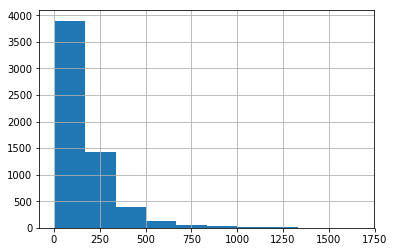

In [33]:
lens.hist();

In [34]:
#train_X.fillna("unknown", inplace=True)
#test_X.fillna("unknown", inplace=True)
#train_val["Review Text"].fillna("unknown", inplace=True)

In [35]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

tweet_tokenizer = TweetTokenizer()

In [36]:
n = train_X.shape[0]

vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tweet_tokenizer.tokenize)

full_text = list(train_X.values) + list(test_X.values)

vectorizer.fit(full_text)

train_vectorized = vectorizer.transform(train_X)
test_vectorized = vectorizer.transform(test_X)

"""
vec = TfidfVectorizer(ngram_range=(1,5), smooth_idf=True, use_idf=True, sublinear_tf=1, max_features=6300, 
                      strip_accents='unicode' )    

vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )


vec = vec.fit(pd.concat([train_X, test_X], axis=0))

trn_term_doc = vec.transform(train_X)
val_term_doc = vec.transform(train_val["Review Text"])
test_term_doc = vec.transform(test_X)
"""

# print(len(vectorizer.get_feature_names()))
print(len(vectorizer.vocabulary_))

6300
6300


In [37]:
print(trn_term_doc.shape)
print(type(trn_term_doc))
print(trn_term_doc.toarray())

(5959, 6300)
<class 'scipy.sparse.csr.csr_matrix'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [38]:
x = trn_term_doc.toarray()
test_term = test_term_doc.toarray()

X_train, X_val, y_train, y_val = train_test_split(np.array(x), np.array(binary_label), random_state=0)

In [39]:
class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_size = 1
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(in_features=hidden_dim * 2, out_features=21)
        self.sig = nn.Sigmoid()
        self.soft = nn.LogSoftmax(dim=0)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.word_dict = None
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.08
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.lstm.weight_ih_l0.data.uniform_(-initrange, initrange)
        self.lstm.weight_hh_l0.data.uniform_(-initrange, initrange)
        
        self.lstm.bias_ih_l0.data.zero_()
        self.lstm.bias_hh_l0.data.zero_()
        
        # self.fc.bias.data.zero_()
        self.dense.bias.data.fill_(0)
        # self.fc.weight.data.uniform_(-initrange, initrange)
        self.dense.weight.data.normal_(0.0, (1.0 / np.sqrt(self.dense.in_features)))
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        
        batch_size = x.size(0)
        
        h_embedding = self.embedding(x)
        h_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        
        h_lstm, _ = self.lstm(h_embedding)
        
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.dense(conc))
        out = self.dropout(conc)
        #out = self.out(out)
        """
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        print(out)
        #sig_out = out.view(batch_size, -1, self.output_size)
        #sig_out = sig_out[:, -1]
        #print(sig_out)
        
        #out = out[lengths - 1, range(len(lengths))]
        """
        return self.sig(out.squeeze())

In [40]:
import torch.nn as nn

class DNNClassifier(nn.Module):
    """
    This is the simple DNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, hidden_dim, input_size, output_size, dropout=0.5):
        """
        Initialize the model by settingg up the various layers.
        """
        super(DNNClassifier, self).__init__()

        self.sig = nn.Sigmoid()        
        # self.word_dict = None
        
        self.fc1 = nn.Linear(input_size, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(p=0.5)
        self.init_weights()
        self.soft = nn.LogSoftmax(dim=0)
        
    def init_weights(m):
        initrange = 0.08
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.normal_(0.0, y)
            m.bias.data.fill_(0)
        
    def forward(self, input_x):
        """
        Perform a forward pass of our model on some input.
        """
        #input_x = input_x.t()
        #lengths = input_x[0,:]        
        x = input_x[0:,1:]
        #print(x)
        #print(input_size)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        out = self.out(x)
        return self.sig(out)

In [41]:
# Hyperparameters
batch_size = 50
num_epochs = 30
# Learning Rate
learning_rate = 0.0001
# Model parameters
# Input size
input_size = X_train.shape[1] - 1
# Output size
output_size = 21
# Embedding Dimension
embedding_dim = 32
# Hidden Dimension
hidden_dim = 128
# Number of RNN Layers
n_layers = 2
#vocabulary size
vocab_size = 6300

# Show stats for every n number of batches
show_every_n_batches = 50

In [42]:
print(X_train)
print(y_train)

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).float().squeeze())
val_sample_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_val).long(), torch.from_numpy(y_val).float().squeeze())
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=batch_size)
var_sample_dl = torch.utils.data.DataLoader(val_sample_ds, batch_size=batch_size)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [43]:
def train(model, train_loader, val_loader, epochs, optimizer, loss_fn, device):
    train_loss = 0
    val_loss = 0Da
    for epoch in range(1, epochs + 1):
        model.train()
        for batch in train_loader:
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            model.zero_grad()
            optimizer.zero_grad()
            
            #batch_len = batch_X.t()[0,:]
            #print(batch_len)
            
            # TODO: Complete this train method to train the model provided.
            output = model.forward(batch_X)
            #print(output)
            
            #_, batch_y = batch_y.max(dim=1)            
            batch_y = torch.autograd.Variable(batch_y)
            #batch_y = batch_y.reshape(-1,1)
            #print(batch_y)
            #print(output)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            #print(loss.item())
            #break
        model.eval()
        for batch in val_loader:
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # model.zero_grad()
            #optimizer.zero_grad()
            # TODO: Complete this train method to train the model provided.
            output = model.forward(batch_X)
            
            #_, batch_y = batch_y.max(dim=1)            
            batch_y = torch.autograd.Variable(batch_y)
            #batch_y = batch_y.reshape(-1,1)
            #print(output)
            
            loss = loss_fn(output, batch_y)            
            val_loss += loss.item()
            #break
        
        total_train_loss = train_loss / len(train_loader)
        total_val_loss = val_loss / len(val_loader)
        
        print("Epoch: {}, BCE Train Loss: {} Valid Loss {}".format(epoch, total_train_loss, total_val_loss))
        val_loss = 0
        train_loss = 0
        #break
    return model

In [44]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [45]:
#model = DNNClassifier(hidden_dim, input_size, output_size).to(device)
model = LSTMClassifier(embedding_dim, hidden_dim, vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
loss_fn = torch.nn.BCELoss()
#loss_fn = nn.MultiLabelSoftMarginLoss()
#loss_fn = nn.BCEWithLogitsLoss()

model_tn = train(model, train_sample_dl, var_sample_dl, num_epochs, optimizer, loss_fn, device)

Epoch: 1, BCE Train Loss: 0.6932063950432672 Valid Loss 0.6931546926498413
Epoch: 2, BCE Train Loss: 0.6931547727849748 Valid Loss 0.6931546926498413
Epoch: 3, BCE Train Loss: 0.6931547727849748 Valid Loss 0.6931546926498413
Epoch: 4, BCE Train Loss: 0.6931547727849748 Valid Loss 0.6931546926498413
Epoch: 5, BCE Train Loss: 0.6931547727849748 Valid Loss 0.6931546926498413
Epoch: 6, BCE Train Loss: 0.6931547727849748 Valid Loss 0.6931546926498413


KeyboardInterrupt: 

In [47]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
